In [21]:
import sys, os 
sys.path.insert(0,r"C:\Users\labadmin\Documents\suite2p")
sys.path.insert(0,r"C:\Users\labadmin\Documents\rastermap")
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
log_file = r"Z:\data\Miguel\MesoscopeLog\mouse_stim_log.xlsx"
log = pd.read_excel(log_file)
log['date'] = pd.to_datetime(log['date'], format="%Y_%m_%d")
# remove all the test ids
log = log[log['id'] != 'test']
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 12 to 87
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                71 non-null     object        
 1   date              71 non-null     datetime64[ns]
 2   block             71 non-null     int64         
 3   session           71 non-null     object        
 4   positive_cat      71 non-null     object        
 5   negative_cat      71 non-null     object        
 6   positive_cat_num  71 non-null     int64         
 7   negative_cat_num  71 non-null     int64         
 8   eff_trials        71 non-null     int64         
 9   prop_rew_wlicks   69 non-null     float64       
 10  prop_nrew_wlics   70 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 6.7+ KB


In [10]:
start_date = "2024-10-15"
end_date = "2024-11-01"
first_pair_period = log[(log['date'] >= start_date) & (log['date'] <= end_date)]

In [11]:
#  grab the last blk per each date
last_blk = first_pair_period.groupby(["id","date"]).last()
last_blk = last_blk.reset_index()
last_blk["DI"] = last_blk["prop_rew_wlicks"]-last_blk["prop_nrew_wlics"]

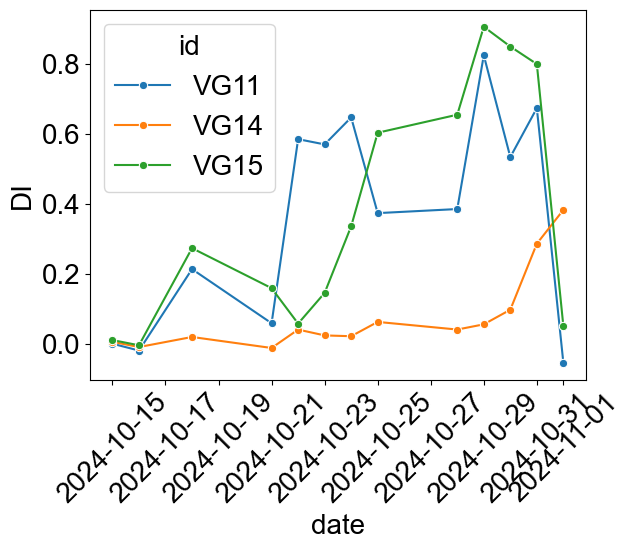

In [12]:
sns.lineplot(data=last_blk, x="date", y="DI", hue="id", marker="o")
plt.xticks(rotation=45)
plt.show()

In [13]:
recorded_session = last_blk[last_blk["date"] == "2024-10-31"].query("id != 'VG14'")
recorded_session

,id,date,block,session,positive_cat,negative_cat,positive_cat_num,negative_cat_num,eff_trials,prop_rew_wlicks,prop_nrew_wlics,DI
11,VG11,2024-10-31,2,Category,Circles,Paved,2,8,255,0.97619,0.30233,0.67386
37,VG15,2024-10-31,2,Category,Circles,Paved,2,8,400,0.94500,0.14500,0.80000


In [14]:
from datetime import datetime, timedelta
def get_lick_df(MouseObject, drop_last_trial=True):
    if "TX" in MouseObject.name:
        df = pd.DataFrame(MouseObject._timeline["Licks"].T, columns=["trial", "distance","alpha","is_rewarded","time", "flag"])
    else:
        df = pd.DataFrame(MouseObject._timeline["Licks"].T, columns=["trial", "distance","alpha","is_rewarded","time", "flag", "istest"])
    df["datetime"] = pd.to_datetime(
        df["time"].apply(
            lambda x: datetime.fromordinal(int(x))
            + timedelta(days=x % 1)
            - timedelta(days=366)
        )
    )
    df = df.assign(distance = df["distance"]*10)
    df = df.assign(date=df["datetime"].dt.date)
    df = df.assign(hour_min_sec=df["datetime"].dt.time)
    df = df.assign(seconds_in_session=(df["datetime"] - df["datetime"][0]).dt.total_seconds())
    if drop_last_trial:
        n_trials = df.trial.unique()[-2].astype(int)
        df = df.loc[df.trial != df.trial.max()]
    else:
        n_trials = df.trial.unique()[-1].astype(int)
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , _ = utils.get_trial_categories(isrewarded, isnew)
    for ix, ttype in enumerate(trial_type):
        df.loc[df.trial == ix+1, "trial_type"] = ttype
    df.drop(["time","datetime","is_rewarded","alpha"], axis=1, inplace=True)
    return df


def get_learning_history(sessions_df):

    def proportion_byblocks(MouseObject, lick_window=(150, 250), n_blocks=4):
        def count_trial(isrewarded, isnew):
            rew_n = (np.logical_not(isnew) * isrewarded).sum()
            nrew_n = (np.logical_not(isnew) * np.logical_not(isrewarded)).sum()
            rewtest_n = (isnew * isrewarded).sum()
            nrewtest_n = (isnew * np.logical_not(isrewarded)).sum()
            counts = {'rewarded': rew_n, 
                    'non rewarded': nrew_n, 
                    'rewarded test': rewtest_n, 
                    'non rewarded test': nrewtest_n}
            return counts

        df = get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        block_size = n_trials//n_blocks
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        isrewarded_split = np.split(isrewarded[:n_blocks * block_size], n_blocks)
        isnew_split = np.split(isnew[:n_blocks * block_size], n_blocks)
        df = df.loc[df.flag != 1]
        prop_dict = {"rewarded": [], "non rewarded": [], "rewarded test": [], "non rewarded test": [], "trial_block": [],  "block_n": []}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance <= lick_window[1])]
        trials_splits = np.arange(1, n_trials, block_size)
        if len(trials_splits) < n_blocks+1:
            trials_splits = np.append(trials_splits, n_trials)
        for i_blk, (rew_block, new_block) in enumerate(zip(isrewarded_split, isnew_split)):
            counts = count_trial(rew_block, new_block)
            for ttype, trial_no in counts.items():
                if trial_no != 0:
                    subdf = df.query(f"trial_type == '{ttype}' & trial >= {trials_splits[i_blk]} & trial < {trials_splits[i_blk+1]}")
                    licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                    prop_dict[ttype].append(licks_in_trialtype / trial_no)
                else:
                    prop_dict[ttype].append(0)
            prop_dict["trial_block"].append((trials_splits[i_blk], trials_splits[i_blk+1]))
            prop_dict["block_n"].append(i_blk)
        df_counts = pd.DataFrame(prop_dict)
        return df_counts

    all_sessions_notTX = sessions_df.query("mname.str.startswith('TX') == False & more_than_4 == False")
    all_first_sessions = all_sessions_notTX.query("n_trials >= 100")
    all_first_sessions['datexp'] = pd.to_datetime(all_first_sessions['datexp'])
    df_byblocks_sessions = pd.DataFrame()
    for row in all_first_sessions.iterrows():
        name = str(row[1]['mname'])
        date = row[1]['datexp'].strftime("%Y_%m_%d")
        blk = str(row[1]['blk'])
        m = utils.load_mouse(name, date, blk, load_neurons=False, load_retinotopy=False)
        tmp_df = proportion_byblocks(m, lick_window=(150, 250), n_blocks=4)
        tmp_df['mname'] = row[1]['mname']
        tmp_df['datexp'] = row[1]['datexp']
        tmp_df['blk'] = row[1]['blk']
        tmp_df['cat_pair'] = row[1]['cat_pair']
        tmp_df['positive_category'] = row[1]['positive_category']
        tmp_df['negative_category'] = row[1]['negative_category']
        tmp_df['train_day'] = row[1]['train_day']
        tmp_df['Session'] = row[1]['Session']
        df_byblocks_sessions = pd.concat([df_byblocks_sessions, tmp_df], axis=0)
    df_byblocks_sessions['cat_pair_n'] = df_byblocks_sessions.apply(get_catpair_n, axis=1)
    df_byblocks_sessions = df_byblocks_sessions.assign(DI = df_byblocks_sessions['rewarded'] - df_byblocks_sessions['non rewarded'], 
                                                    GI = df_byblocks_sessions['rewarded test'] - df_byblocks_sessions['non rewarded test'])
    training_day = df_byblocks_sessions['train_day'].unique()
    i = 0
    overall_days = np.arange(20)
    for day in training_day:
        for block_n in range(4):
            df_byblocks_sessions.loc[(df_byblocks_sessions['train_day'] == day) & (df_byblocks_sessions['block_n'] == block_n), 'overall_block'] = overall_days[i]
            i += 1
    return df_byblocks_sessions

def licksraster(MouseObject, ax):
    import seaborn as sns
    """
    Plot the lick data.

    Parameters
    ----------
    MouseObject : Mouse object
        Mouse object containing the data
    first_lick : bool
        If True, plot the first lick distribution over trials.
    fsize : tuple
        Figure size.
    lick_counter_lim : tuple
        Limits for the lick counter.

    Returns
    -------
    fig : figure
        Figure of lick data.
    """
    opt_dict = {
        "rewarded": "tab:green",
        "non rewarded": "tab:red",
        "rewarded test": "tab:cyan",
        "non rewarded test": "tab:orange",
    }
    #pct_axis = fig.add_subplot(grid[-2:, 5:])
    lick = get_lick_df(MouseObject, drop_last_trial=True)
    n_trials = int(lick.trial.max())
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , counts = utils.get_trial_categories(isrewarded, isnew)
    for key, value in counts.items():
        lick.loc[np.where(lick["trial_type"] == key)[0], "Weight"] = value
    lick = lick[lick["flag"] != 1]
    #lick = lick.iloc[::2]
    category_number = len(np.unique(trial_type))
    if category_number == 4:
        categories = ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]
    elif category_number == 2:
        categories = ["rewarded", "non rewarded"]
        

    for category in categories:
        position = lick[lick["trial_type"] == category]["distance"]
        trial = lick[lick["trial_type"] == category]["trial"]
        if category in ["rewarded", "non rewarded"]:
            ax.scatter(
                position,
                trial,
                marker="o",
                label=category,
                alpha=0.5,
                c = opt_dict[category],
                s=5,
            )
        elif category == "rewarded test":
            ax.scatter(
                position,
                trial,
                marker="X",
                alpha=0.2,
                label=category,
                c = opt_dict[category],
                s=5,
            )
        else:
            ax.scatter(
                position,
                trial,
                marker="X",
                alpha=0.2,
                label=category,
                c = opt_dict[category],
                s=5,
            )

    ax.set_xlabel("lick position (cm)")
    ax.set_ylabel("trial")
    ax.set_xlim(0, lick["distance"].max() + 10)
    #init_text = lick["distance"].max() -30
    i = 0
    change_dict = {'rewarded': 'train A', 'non rewarded': 'train B', 'rewarded test': 'test A', 'non rewarded test': 'test B'}
    for category in categories:
        ax.text(310,320-i,change_dict[category],color=opt_dict[category], size=12)
        i+=27
    ax.set_ylim(0, n_trials+30)
    ax.set_xticks([0, 150, 250, 400])
    ax.fill_betweenx([0, n_trials+19], [150],[250], color='tab:green', alpha=0.2)
    ax.vlines(300,0, n_trials+19, color='k', linestyle='--', alpha = 0.3)
    #add text for reward region
    ax.text(145, n_trials+30, "reward \n region", color='tab:green', size=12)
    ax.tick_params(axis='both', which='major')
    sns.despine()

def licks(MouseObject, first_lick=True, bin_num=60, fig_size=(12, 12), lick_window=(45, 110)
):
    

    def proportion_licks(MouseObject, lick_window=(150,250)):
        '''
        returns a dictionary with the proportion of licks in a given window per each trial type

        Parameters
        ----------
        MouseObject : Mouse object
            Mouse object with loaded behavior
        lick_window : tuple, optional
            position window in which to count licks, by default (45,110)
        '''
        df = utils.get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        df = df.loc[df.flag != 1]
        prop_dict = {}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance < lick_window[1])]
        _ , counts = utils.get_trial_categories(isrewarded, isnew)
        for item in counts.items():
            if item[1] != 0:
                subdf = df.query(f"trial_type == '{item[0]}'")
                licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                prop_dict[item[0]] = licks_in_trialtype / item[1]
        return prop_dict
    import seaborn as sns
    """
    Plot the lick data.

    Parameters
    ----------
    MouseObject : Mouse object
        Mouse object containing the data
    first_lick : bool
        If True, plot the first lick distribution over trials.
    fsize : tuple
        Figure size.
    lick_counter_lim : tuple
        Limits for the lick counter.

    Returns
    -------
    fig : figure
        Figure of lick data.
    """
    opt_dict = {
        "rewarded": "tab:green",
        "non rewarded": "tab:red",
        "rewarded test": "tab:cyan",
        "non rewarded test": "tab:orange",
    }
    fig = plt.figure(figsize=fig_size)
    grid = plt.GridSpec(6, 6, hspace=0.2, wspace=1)
    main_ax = fig.add_subplot(grid[1:, :5])
    x_hist = fig.add_subplot(grid[:1, :5], sharex=main_ax)
    pct_axis = fig.add_subplot(grid[-2:, 5:])
    lick = utils.get_lick_df(MouseObject, drop_last_trial=True)
    n_trials = int(lick.trial.max())
    isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
    isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
    trial_type , counts = utils.get_trial_categories(isrewarded, isnew)
    prp_dict = proportion_licks(MouseObject, lick_window=lick_window)
    for key, value in counts.items():
        lick.loc[np.where(lick["trial_type"] == key)[0], "Weight"] = value
    lick = lick[lick["flag"] != 1]
    category_number = len(np.unique(trial_type))
    if category_number == 4:
        categories = ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]
    elif category_number == 2:
        categories = ["rewarded", "non rewarded"]
        
    if first_lick:
        lick = lick.groupby("trial").min().reset_index()



    for category in categories:
        position = lick[lick["trial_type"] == category]["distance"]
        trial = lick[lick["trial_type"] == category]["trial"]
        if category in ["rewarded", "non rewarded"]:
            main_ax.scatter(
                position,
                trial,
                marker="8",
                label=category,
                alpha=0.5,
                c = opt_dict[category],
                s=40,
            )
        else:
            main_ax.scatter(
                position,
                trial,
                marker="8",
                alpha=0.7,
                label=category,
                c = opt_dict[category],
                s=80,
            )
        pct_axis.bar(category, prp_dict[category] * 100, color=opt_dict[category], alpha=0.5)
        

    sns.histplot(
        data=lick,
        hue="trial_type",
        x="distance",
        kde=True,
        alpha=0.3,
        weights= 1 / lick["Weight"],
        bins=bin_num,
        hue_order=categories,
        palette = [opt_dict[category] for category in categories],
        ax=x_hist,
        legend=False,
    )

    pct_axis.axhline(y=80, color="k", linestyle="--", alpha=0.5)
    pct_axis.set_xticks([])
    pct_axis.set_ylabel(f"% trials with one lick \n between {lick_window[0]} and {lick_window[1]} cm", size=12)
    pct_axis.set_xlabel("")
    pct_axis.set_ylim(0, 100)
    main_ax.set_xlabel("Position (cm)", fontsize=15)
    main_ax.set_ylabel("Trial",fontsize=15)
    main_ax.set_ylim(0,360)
    main_ax.set_xlim(0, lick["distance"].max() + 10)
    i = 0
    for category in categories:
        main_ax.text(300,300-i,category,color=opt_dict[category],size=15)
        i+=15
    main_ax.set_ylim(0, n_trials+3)
    x_hist.get_xaxis().set_visible(False)
    x_hist.set_xlabel("")
    x_hist.set_ylabel("Fraction", fontsize=15)
    main_ax.tick_params(axis='both', which='major', labelsize=13)
    x_hist.tick_params(axis='both', which='major', labelsize=13)
    sns.despine()

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_31_2.mat not found, trying with fname: VG15_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


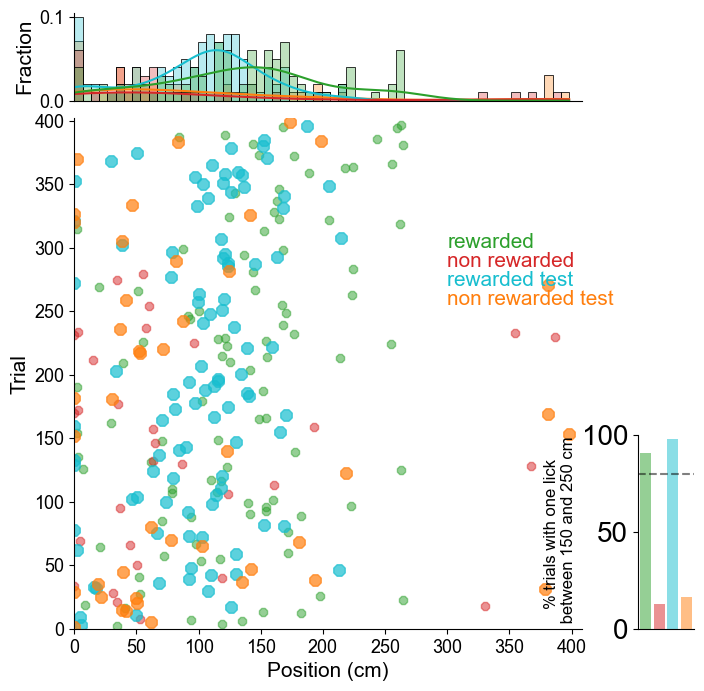

In [15]:
m1 = utils.load_mouse('VG15','2024_10_31', '2', load_neurons=False, load_retinotopy=False)
licks(m1, first_lick=True, bin_num=60, fig_size=(8, 8), lick_window=(150, 250))

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_31_2.mat not found, trying with fname: VG11_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


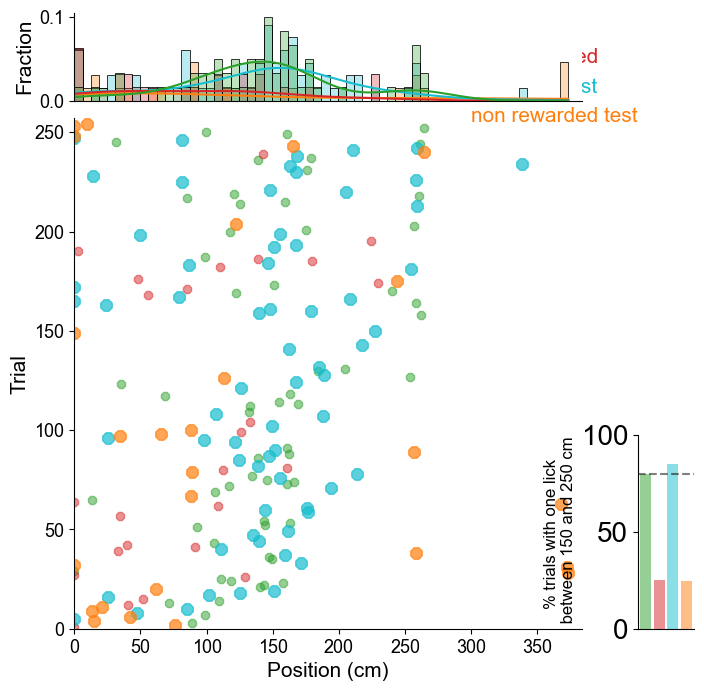

In [16]:
m1 = utils.load_mouse('VG11','2024_10_31', '2', load_neurons=False, load_retinotopy=False)
licks(m1, first_lick=True, bin_num=60, fig_size=(8, 8), lick_window=(150, 250))

In [19]:
m1 = utils.load_mouse('VG15','2024_10_31', '2', load_neurons=False, load_retinotopy=False)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_31_2.mat not found, trying with fname: VG15_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings'])


In [22]:
m1.load_neurons_VG(dual_plane=True, Fs=3, return_F = False, return_iscell = False, verbose=False)

planes: 20


100%|██████████| 20/20 [06:07<00:00, 18.40s/it]


In [23]:
utils.properties(m1)

dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr'])

Text(0.5, 0, 'Time (frames)')

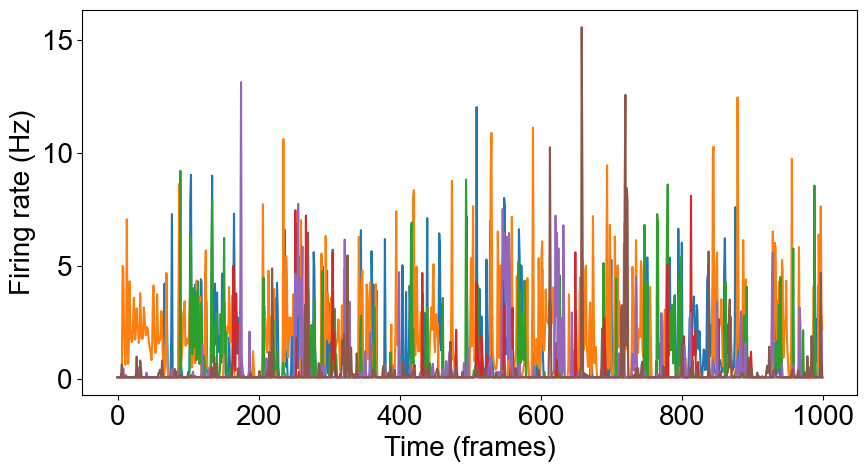

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(m1._spks[0,:1000])
ax.plot(m1._spks[1,:1000])
ax.plot(m1._spks[2,:1000])
ax.plot(m1._spks[3,:1000])
ax.plot(m1._spks[4,:1000])
ax.plot(m1._spks[55,:1000])
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (frames)')

Text(0.5, 0, 'SNR')

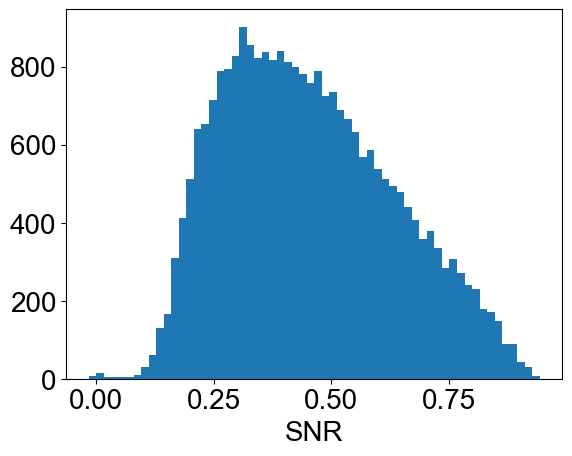

In [39]:
plt.hist(m1._snr, bins=60);
plt.xlabel("SNR")